<a href="https://colab.research.google.com/github/cyuancheng/Stock_Prediction/blob/master/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stock price prediction using ARIMA and LSTM

In [24]:
!pip install pmdarima

     |████████████████████████████████| 1.4MB 9.1MB/s 


In [0]:
import pandas as pd
from pandas_datareader.data import DataReader
from datetime import date

import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

import os
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [0]:
# set start and end date
start = date(2000, 1, 1)
end = date(2019,11,29)

Load stock data from yahoo finance

In [0]:
ticker = 'QQQ'
data_source = 'yahoo'
stock_data = DataReader(ticker, data_source, start, end)

In [30]:
display(stock_data.head(3))
display(stock_data.tail(3))

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,96.1875,90.7500,96.1875,94.75,36345200.0,83.116226
2000-01-04,93.5000,87.9375,92.0000,88.25,33786600.0,77.414307
2000-01-05,89.6250,84.2500,87.5000,86.00,42496600.0,75.440605


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-11-26,204.869995,204.050003,204.350006,204.610001,14780600.0,204.610001
2019-11-27,206.050003,204.889999,205.139999,206.039993,16963100.0,206.039993
2019-11-29,205.830002,205.000000,205.520004,205.100006,9854600.0,205.100006


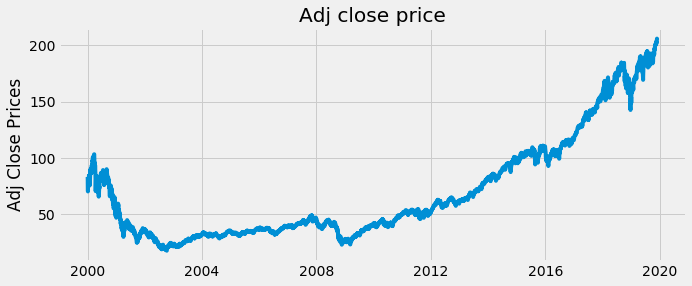

In [34]:
# show plot

#plot close price
plt.figure(figsize=(10,4))
plt.grid(True)
plt.xlabel('')
plt.ylabel('Adj Close Prices')
plt.plot(stock_data['Adj Close'])
plt.title('Adj close price')
plt.show()


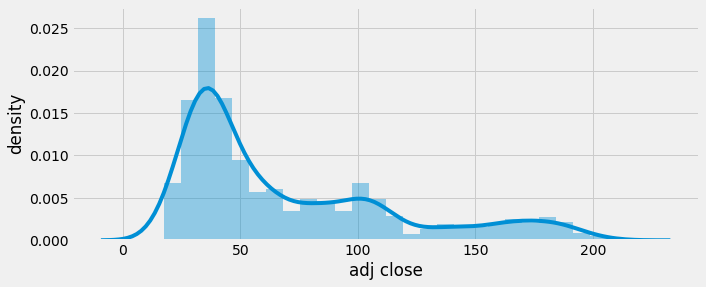

In [39]:
plt.figure(figsize=(10,4))
sns.distplot(stock_data['Adj Close'])
plt.xlabel('adj close')
plt.ylabel('density')
plt.show()

Check if the time series is stationary or not using Dickey Fuller test

In [0]:
#Test for staionarity
def test_stationarity(data):
    '''
    test the stationarity of time series
    using rolling average
    import: time series data (xy)
    '''
    #Determing rolling statistics
    rol_mean = data.rolling(12).mean()
    rol_std = data.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(data, color='blue',label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Average and Standard Deviation')
    plt.show(block=False)
    
    print("Result of Dickey Fuller test")
    adft = adfuller(data,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

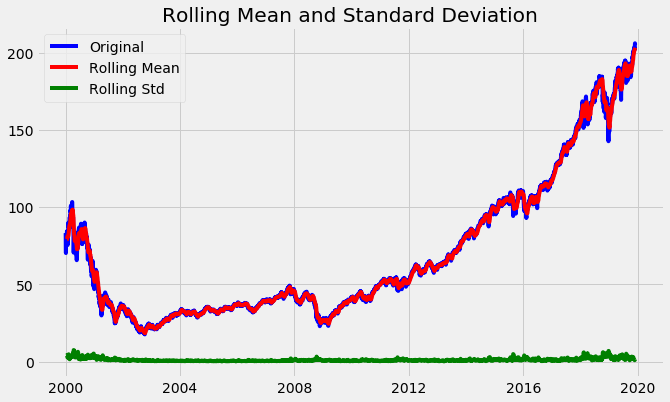

Results of Dickey Fuller test
Test Statistics                   2.244294
p-value                           0.998917
No. of lags used                 29.000000
Number of observations used    4980.000000
critical value (1%)              -3.431664
critical value (5%)              -2.862121
critical value (10%)             -2.567079
dtype: float64


In [41]:
test_stationarity(stock_data['Adj Close'])

p-value > 0.05, so the Null hypothesis can not be rejected. --> the time-series data is non-stationary.

In order to be able to analyze the stationary time-series data, we need to seperate seasonality and trend from the data.

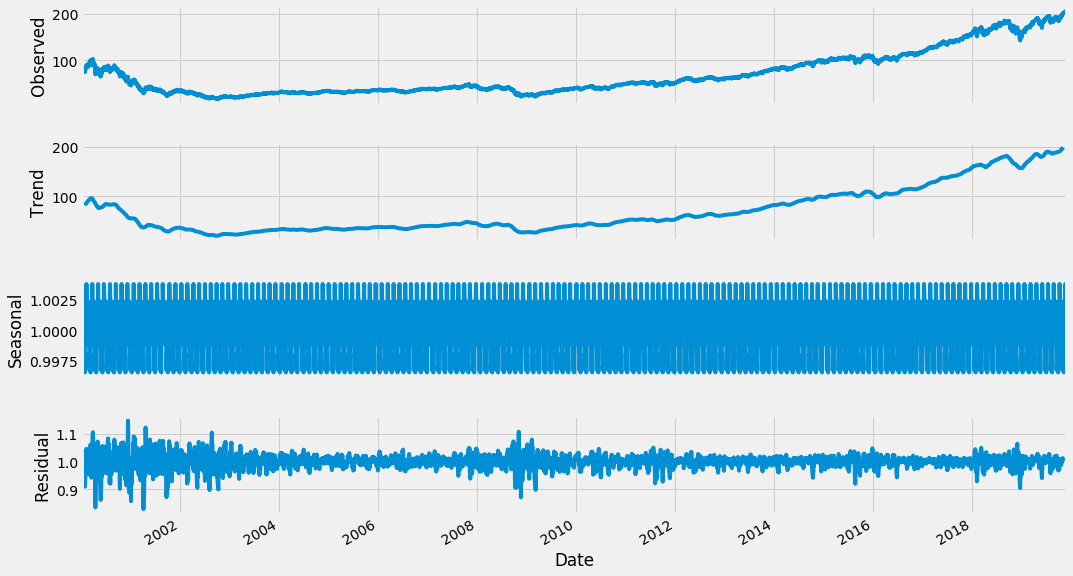

In [51]:
data_decompose = seasonal_decompose(stock_data['Adj Close'], model='multiplicative', freq = 30)

fig = data_decompose.plot()  
fig.set_size_inches(16, 9)